In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "None"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"

import multiprocessing
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

# %env XLA_FLAGS="--xla_force_host_platform_device_count=10"
%env XLA_FLAGS

'--xla_force_host_platform_device_count=10'

In [5]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


### define Bézier curve

In [6]:
import jax.experimental
import jax.numpy as jnp
from jax import jit, grad
from scipy.special import binom


def log_value(x):
  # This could be an actual logging call; we'll use
  # print() for demonstration
  if x.shape[0] != 200:
    print("T min:", x.shape, x.min(), x)


def log_value2(x):
    print("Shape, min, val:", x.shape, x.min(), x)


class BezierCoeff:
    """
    returns the coefficients for the Bézier curve.
    For Quadratic Bézier curves num_bends=2
    """

    def __init__(self, num_bends):
        # with float dtype i get nans because 0.**0. produces nan "https://github.com/google/jax/issues/14397"
        self.range = jnp.arange(0, num_bends)[None, :]
        self.rev_range = jnp.arange((num_bends - 1), -1, -1)[None, :]
        self.binom = jnp.array(
            binom(num_bends - 1, jnp.arange(num_bends), dtype=jnp.float32))[None, :]

    def __call__(self, t):
        if t.ndim == 1:
            t = t[:, None]  # (t, 1)
        return self.binom * jnp.power(t, self.range) * jnp.power((1.0 - t), self.rev_range)


class BezierCurve:
    """
    Returns the coefficients for the Bézier curve.
    For Quadratic Bézier curves num_bends=2
    """

    def __init__(self, num_bends):
        self.range = jnp.arange(0, num_bends)[None, :]
        self.rev_range = jnp.arange((num_bends - 1), -1, -1)[None, :]
        self.binom = jnp.array(
            binom(num_bends - 1, jnp.arange(num_bends), dtype=jnp.float32))[None, :]
        self.bezier_coeff_inv = BezierCoeff(num_bends - 1)

    def derivative_bezier_unsafe(self, t, cp):
        n = cp.shape[0] - 1
        coeff = self.bezier_coeff_inv(t)
        cp_diff = cp[1:] - cp[:-1]
        return jnp.einsum('sj,j...->s...', coeff, cp_diff) * n

    def derivative_bezier(self, t, cp):
        if t.ndim == 1:
            t = t[:, None]  # (t, 1)
        t_ = t
        # t_ = jnp.clip(t, 0., 1.)
        n = cp.shape[0]-1
        coeff = self.bezier_coeff_inv(t_)
        cp_diff = cp[1:] - cp[:-1]
        return jnp.einsum('sj,j...->s...', coeff, cp_diff) * n

    def __call__(self, t, cp):
        if t.ndim == 1:
            t = t[:, None]  # (t, 1)
        # t_ = jnp.clip(t, 0., 1.)
        t_ = t
        # jax.debug.print("t: {}".format(t.min()))
        # jax.debug.callback(log_value, t)
        # print("t_:", t_.min())
        bezier_coeff = self.binom * \
            jnp.power(t_, self.range) * jnp.power((1.0 - t_), self.rev_range)
        p_t = jnp.einsum('sk,k...->s...', bezier_coeff, cp)

        # v_t0, v_t1 = self.derivative_bezier_unsafe(jnp.array([0., 1.]), cp)
        # # we should not normalize the tangent vectors because then we would change the speed along t dimension which is not what we want.
        # # (dense distribution at the endpoints because different speed induce different step sizes in the t dimension?)
        # # v_t0 /= jnp.linalg.norm(v_t0)
        # # v_t1 /= jnp.linalg.norm(v_t1)

        # t_lt_0 = t < 0.
        # t_gt_1 = t > 1.

        # # add the linear extrapolation terms for t<0 and t>1.
        # # if jnp.any(t_lt_0):
        # p_t += jnp.multiply(v_t0[None, :], jnp.where(t_lt_0, t, 0.))

        # # if jnp.any(t_gt_1):
        # p_t += jnp.multiply(v_t1[None, :], (jnp.where(t_gt_1, t, 1.) - 1.))

        # jax.debug.callback(log_value2, p_t)

        return p_t


BezierCurve(3)(jnp.array([-0.5, 0., 0.5, 0.8, 1., 1.1]), jnp.array(
    [[-3., -3.], [-4., 4.], [0., -3.5]]))

Array([[ -0.75     , -13.625    ],
       [ -3.       ,  -3.       ],
       [ -2.75     ,   0.375    ],
       [ -1.4      ,  -1.0800002],
       [  0.       ,  -3.5      ],
       [  0.8500002,  -5.1450005]], dtype=float32)

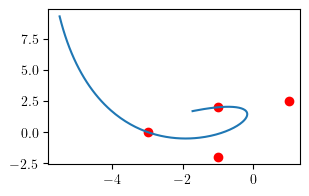

In [7]:
control_points = jnp.array([[-3., 0.],
                            [-1., 1.],
                            [1., -1.],
                            [3., 0]])
control_points = jnp.array([[-3., 0.],
                            [-1., -2.],
                            [1., 2.5],
                            [-1., 2.]])


curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)

tt = jnp.linspace(-0.5, 1.1, 200)
c_t = curve(tt)
plt.plot(c_t[:, 0], c_t[:, 1])
plt.scatter(control_points[:, 0], control_points[:, 1], color='red')

### ortho space with sign flip

#### Gram Schmidt with possible sign flip 

(25, 2) (25, 3, 2)


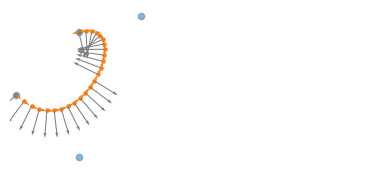

In [8]:
def generate_ortho_space_sign_flip_possible(t, d_bezier):
    d = d_bezier(t)
    v1 = d / jnp.linalg.norm(d, axis=-1, keepdims=True)

    def single_orhto(v1):
        ortho = []
        ortho.append(v1)
        for v in control_points[1:-1]:  # test vectors
            proj = jnp.zeros_like(ortho[0])
            for u in ortho:  # ortho vectors
                proj += jnp.dot(u, v) * u
            v_ortho = v - proj
            # jax.debug.print("v_ortho: {}".format(jnp.linalg.norm(v_ortho)))
            v_ortho = v_ortho / jnp.linalg.norm(v_ortho)
            # # make sure each ortho vector points in the same direction aligned to the first vector (gradient along bezier curve)
            # v_ortho = jnp.where(jnp.cross(v1, v_ortho) < 0, -v_ortho, v_ortho)
            ortho.append(v_ortho)
        return jnp.stack(ortho, axis=0)

    ortho = jax.vmap(single_orhto, in_axes=(0))(v1)
    return ortho  # (#t_samples, #ortho, k)

def get_bezier_dirs(t):
    t = t[:, None]
    curve_points = curve(t)
    space = generate_ortho_space_sign_flip_possible(t, d_bezier)
    return curve_points, space


t_test = jnp.linspace(0., 1., 25)
curve_points, space = get_bezier_dirs(t_test)
print(curve_points.shape, space.shape)
fig, axs = plt.subplots(1,2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1], color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=20.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')
# axs[0].set_xlabel(r'$\varphi_1$')
# axs[0].set_ylabel(r'$\varphi_2$')

(25, 2) (25, 2, 2)


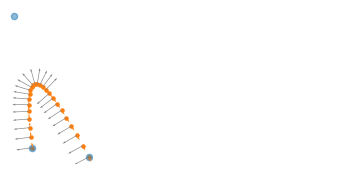

In [10]:
# problem because test point is vector from origin

control_points = jnp.array([[-3., -3.],
                            [-4., 4.],
                            [0., -3.5]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)

t_test = jnp.linspace(0., 1., 25)
curve_points, space = get_bezier_dirs(t_test)
print(curve_points.shape, space.shape)

fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

#### with frenet frame

(25, 2) (25, 2, 2)


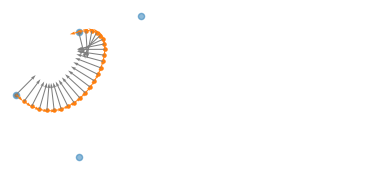

In [11]:
def generate_ortho_space_frenet_n_bein(t, d_bezier):
    def ortho_at_one_t(t):
        # tangent vector
        d = d_bezier(t).squeeze()
        v1 = d / jnp.linalg.norm(d, axis=-1, keepdims=True)
        
        ortho = v1[None, :]
        dev_fn = d_bezier
        for i in range(1, min(control_points.shape[0]-1, control_points.shape[1])):
            dev_fn = jax.jacfwd(dev_fn) # use second, third, ... derivative
            
            # gram-schmidt orthogonalization
            proj = jnp.zeros_like(ortho[0])
            v = dev_fn(t).squeeze() # test vectors comes from derivative of bezier curve
            for u in ortho:  # ortho vectors
                proj += jnp.dot(u, v) * u
            v_ortho = v - proj # subtract all orthogonal projections
            v_ortho /= jnp.linalg.norm(v_ortho) # normalize
            ortho = jnp.concatenate((ortho, v_ortho[None, :]), axis=0)
        return ortho
    return jax.vmap(ortho_at_one_t)(t)


control_points = jnp.array([[-3., 0.],
                            [-1., -2.],
                            [1., 2.5],
                            [-1., 2.]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)

t_test = jnp.linspace(0., 1., 25)
space = generate_ortho_space_frenet_n_bein(t_test, d_bezier)
curve_points = curve(t_test)

print(curve_points.shape, space.shape)
fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

(25, 2) (25, 2, 2)


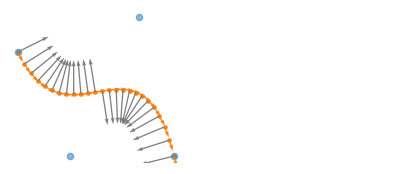

In [12]:
control_points = jnp.array([[-2.5, 1.],
                            [-1., -2.],
                            [1., 2.],
                            [2., -2.]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)

space = generate_ortho_space_frenet_n_bein(t_test, d_bezier)
curve_points = curve(t_test)
print(curve_points.shape, space.shape)

fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

(25, 2) (25, 2, 2)


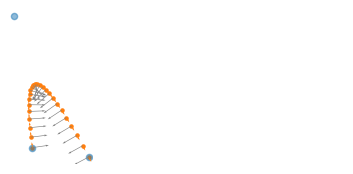

In [13]:
control_points = jnp.array([[-3., -3.],
                            [-4., 4.],
                            [0., -3.5]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)

space = generate_ortho_space_frenet_n_bein(t_test, d_bezier)
curve_points = curve(t_test)
print(curve_points.shape, space.shape)

fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

(25, 2) (25, 2, 2)


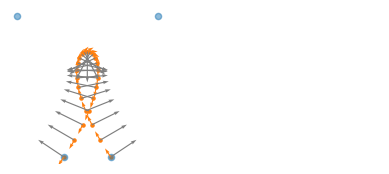

In [14]:
control_points = jnp.array([[1., -3.],
                            [-3., 3.],
                            [3, 3.],
                            [-1., -3]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)

space = generate_ortho_space_frenet_n_bein(t_test, d_bezier)
curve_points = curve(t_test)
print(curve_points.shape, space.shape)

fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

#### new Method motivated from parallel transport (or vlt Rotation Minimizing Frames?)
all together
1. init curve accoring split points
2. compute coordinate system at any point t

In [15]:
def init_curve_frame(d_bezier):
    # find U-Turns
    # find the change in direction of the tangent vector of larger than +-45 degrees
    t_grid = jnp.linspace(0., 1., 200)
    tangents = d_bezier(t_grid)
    tangents = tangents / jnp.linalg.norm(tangents, axis=-1, keepdims=True)
    def scan_fn(current_tangent, tangent):
        dot = jnp.dot(current_tangent, tangent)
        lim = np.cos(np.deg2rad(45)) + 0.05 # +-45 degree
        current_tangent = jnp.where(dot>lim, current_tangent, tangent) # if u-turn set current_tangent to the new one
        return current_tangent, jnp.where(dot > lim, 0,1) # 0 if not u-turn, 1 if u-turn

    _, idx = jax.lax.scan(scan_fn, tangents[0], tangents)
    t_cut = t_grid[idx == 1]
    t_cut = jnp.concatenate((jnp.array([0.]), t_cut))

    def frenet_frame_at(t, d_bezier):
        # tangent vector
        d = d_bezier(t)
        v1 = d / jnp.linalg.norm(d, axis=-1, keepdims=True)

        ortho = v1
        dev_fn = d_bezier
        for i in range(1, min(control_points.shape[0]-1, control_points.shape[1])):
            dev_fn = jax.jacfwd(dev_fn)  # use second, third, ... derivative

            # gram-schmidt orthogonalization
            proj = jnp.zeros_like(ortho[0])
            # test vectors comes from derivative of bezier curve
            v = dev_fn(t).squeeze()
            for u in ortho:  # ortho vectors
                proj += jnp.dot(u, v) * u
            v_ortho = v - proj  # subtract all orthogonal projections
            v_ortho /= jnp.linalg.norm(v_ortho)  # normalize
            ortho = jnp.concatenate((ortho, v_ortho[None, :]), axis=0)
        return ortho
    init_space_at_t0 = frenet_frame_at(jnp.array([1e-4]), d_bezier)

    # at each t_i we have to generate the orthogonal space
    # we can use the previous orthogonal space to generate the new one at t+1
    def ortho_frame_from_previous_frame(ortho_t0, t):
        # tangent vector
        d = d_bezier(t)
        v1 = d / jnp.linalg.norm(d, axis=-1, keepdims=True)

        ortho_t1 = v1

        for i in range(1, min(control_points.shape[0]-1, control_points.shape[1])):
            test_v = ortho_t0[i]  # ortho_t0 is the ortho_t space at time t to generate ortho_{t+1}
            # gram-schmidt orthogonalization
            proj = jnp.zeros_like(ortho_t1[0])
            # test vectors comes from derivative of bezier curve
            for u in ortho_t1:  # ortho vectors
                proj += jnp.dot(u, test_v) * u
            v_ortho = test_v - proj  # subtract all orthogonal projections
            v_ortho /= jnp.linalg.norm(v_ortho)  # normalize
            ortho_t1 = jnp.concatenate((ortho_t1, v_ortho[None, :]), axis=0)
        return ortho_t1, ortho_t1

    last_state, ortho_at_tcut = jax.lax.scan(
        ortho_frame_from_previous_frame, init_space_at_t0, t_cut)
    print(f"Stores {len(t_cut)} orthogonal frames  \nwith ortho frame shape {ortho_at_tcut.shape}")
    return t_cut, ortho_at_tcut

def generate_ortho_parallel_transport(t, d_bezier, t_cut, ortho_at_tcut):
    def get_bin(t, t_bins):
        bin_idx = jnp.argmax(t_bins > t) - 1
        bin_idx = jnp.where(t < t_bins[0], 0, bin_idx)
        bin_idx = jnp.where(t > t_bins[-1], len(t_bins)-1, bin_idx)
        return bin_idx

    def ortho_at_one_t(t, d_bezier, t_cut, ortho_at_tcut):
        # tangent vector
        d = d_bezier(t)
        v1 = d / jnp.linalg.norm(d, axis=-1, keepdims=True)

        ortho = v1
        bin_idx = get_bin(t, t_cut)
        for i in range(1, min(control_points.shape[0]-1, control_points.shape[1])):
            # gram-schmidt orthogonalization
            proj = jnp.zeros_like(ortho[0])
            # test vectors comes from derivative of bezier curve
            # ortho_t0 is the ortho_t space at time t to generate ortho_{t+1}
            v = ortho_at_tcut[bin_idx, i]
            for u in ortho:  # ortho vectors
                proj += jnp.dot(u, v) * u
            v_ortho = v - proj  # subtract all orthogonal projections
            v_ortho /= jnp.linalg.norm(v_ortho)  # normalize
            ortho = jnp.concatenate((ortho, v_ortho[None, :]), axis=0)
        return ortho

    ortho = jax.vmap(ortho_at_one_t, in_axes=(0, None, None, None))(
        t, d_bezier, t_cut, ortho_at_tcut)
    return ortho  # (#t_samples, #ortho, k)

Stores 4 orthogonal frames  
with ortho frame shape (4, 2, 2)
(15, 2) (15, 2, 2)


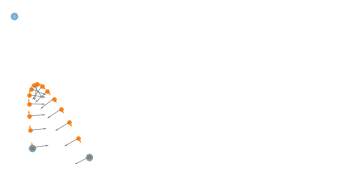

In [16]:
control_points = jnp.array([[-3., -3.],
                            [-4., 4.],
                            [0., -3.5]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)
t_test = jnp.linspace(0., 1., 15)

t_cut, ortho_at_tcut = init_curve_frame(d_bezier)
space = generate_ortho_parallel_transport(
    t_test, d_bezier, t_cut, ortho_at_tcut)
curve_points = curve(t_test)    

print(curve_points.shape, space.shape)

fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)
(15, 2) (15, 2, 2)


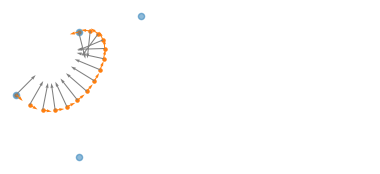

In [17]:
control_points = jnp.array([[-3., 0.],
                            [-1., -2.],
                            [1., 2.5],
                            [-1., 2.]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)
t_test = jnp.linspace(0., 1., 15)

t_cut, ortho_at_tcut = init_curve_frame(d_bezier)
space = generate_ortho_parallel_transport(
    t_test, d_bezier, t_cut, ortho_at_tcut)
curve_points = curve(t_test)

print(curve_points.shape, space.shape)
fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

Stores 4 orthogonal frames  
with ortho frame shape (4, 2, 2)
(30, 2) (30, 2, 2)


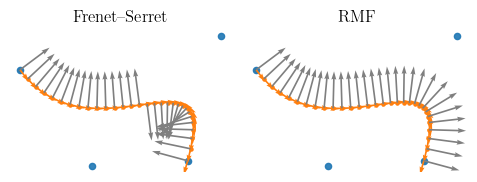

In [19]:
t_test = jnp.linspace(0., 1., 30)
control_points = jnp.array([[-2.5, 1.],
                            [-1., -1.],
                            [1.7, 1.7],
                            [1., -.9]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)

space = generate_ortho_space_frenet_n_bein(t_test, d_bezier)
curve_points = curve(t_test)

t_cut, ortho_at_tcut = init_curve_frame(d_bezier)
space_rmf = generate_ortho_parallel_transport(
    t_test, d_bezier, t_cut, ortho_at_tcut)
curve_points_rmf = curve(t_test)

print(curve_points.shape, space.shape)
fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=.9)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=6.)
axs[0].set_aspect('equal', adjustable='box')

# plot rmf results
axs[1].scatter(curve_points_rmf[:, 0], curve_points_rmf[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[1].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=.9)
axs[1].quiver(curve_points_rmf[:, 0], curve_points_rmf[:, 1],
              space_rmf[:, 0, 0], space_rmf[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[1].quiver(curve_points_rmf[:, 0], curve_points_rmf[:, 1],
              space_rmf[:, 1, 0], space_rmf[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=6.)
axs[1].set_aspect('equal', adjustable='box')

for ax in axs:
    ax.axis('off')
axs[0].set_title("Frenet–Serret")
axs[1].set_title("RMF")
fig.tight_layout()
fig.subplots_adjust(hspace=0.)
plt.savefig("figures/rmf_vs_TNB_frame_comparison.pdf")

Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)
(15, 2) (15, 2, 2)


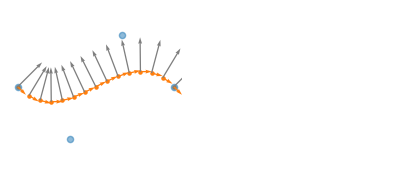

In [20]:
control_points = jnp.array([[-3., 0.],
                            [-1., -2.],
                            [1., 2.],
                            [3., 0.]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)
t_test = jnp.linspace(0., 1., 15)

t_cut, ortho_at_tcut = init_curve_frame(d_bezier)
space = generate_ortho_parallel_transport(
    t_test, d_bezier, t_cut, ortho_at_tcut)
curve_points = curve(t_test)

print(curve_points.shape, space.shape)
fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)
(15, 2) (15, 2, 2)


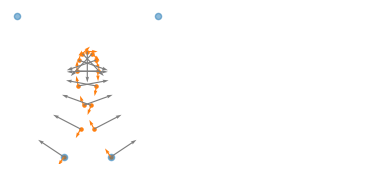

In [21]:
control_points = jnp.array([[1., -3.],
                            [-3., 3.],
                            [3, 3.],
                            [-1., -3]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)
t_test = jnp.linspace(0., 1., 15)

t_cut, ortho_at_tcut = init_curve_frame(d_bezier)
space = generate_ortho_parallel_transport(
    t_test, d_bezier, t_cut, ortho_at_tcut)
curve_points = curve(t_test)

print(curve_points.shape, space.shape)
fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

Stores 7 orthogonal frames  
with ortho frame shape (7, 3, 3)
(15, 3) (15, 3, 3)


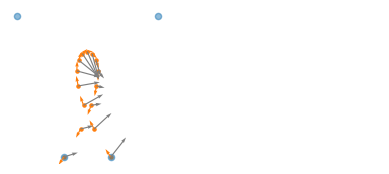

In [22]:
control_points = jnp.array([[1., -3., 0.],
                            [-3., 3., 3.],
                            [3, 3., -3.],
                            [-1., -3, 0.]])
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)
t_test = jnp.linspace(0., 1., 15)

t_cut, ortho_at_tcut = init_curve_frame(d_bezier)
space = generate_ortho_parallel_transport(
    t_test, d_bezier, t_cut, ortho_at_tcut)
curve_points = curve(t_test)

print(curve_points.shape, space.shape)
fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 1],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 1],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 0, 0], space[:, 0, 1], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 1],
              space[:, 1, 0], space[:, 1, 1], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

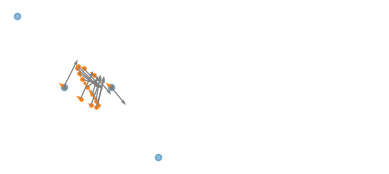

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
axs[0].scatter(curve_points[:, 0], curve_points[:, 2],
               color=plt.get_cmap('tab10')(1), s=5)
axs[0].scatter(control_points[:, 0], control_points[:, 2],
               color=plt.get_cmap('tab10')(0), s=20, alpha=0.5)
# axs[0].quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
axs[0].quiver(curve_points[:, 0], curve_points[:, 2],
              space[:, 0, 0], space[:, 0, 2], color=plt.get_cmap('tab10')(1), scale=15.)
axs[0].quiver(curve_points[:, 0], curve_points[:, 2],
              space[:, 1, 0], space[:, 1, 2], color=plt.get_cmap('tab10')(7), scale=5.)
axs[0].set_aspect('equal', adjustable='box')
for ax in axs:
    ax.axis('off')

In [24]:
# make a 3D plot with quivers
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(curve_points[:, 0], curve_points[:, 1], curve_points[:, 2], c='b')
ax.scatter(*control_points.T, c='r', label='control points')
ax.quiver(curve_points[:, 0], curve_points[:, 1], curve_points[:, 2],
          space[:, 0, 0], space[:, 0, 1], space[:, 0, 2], color='g', label='tanget')
ax.quiver(curve_points[:, 0], curve_points[:, 1], curve_points[:, 2],
            space[:, 1, 0], space[:, 1, 1], space[:, 1, 2], color='cyan', label='normal')
ax.quiver(curve_points[:, 0], curve_points[:, 1], curve_points[:, 2],
            space[:, 2, 0], space[:, 2, 1], space[:, 2, 2], color='magenta', label='binormal')
plt.legend()

RuntimeError: 'widget is not a recognised GUI loop or backend name

<Figure size 1000x1000 with 0 Axes>

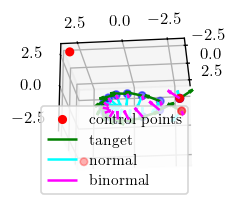

<Figure size 1000x1000 with 0 Axes>

In [77]:
%matplotlib inline
plt.figure(figsize=(10, 10))

Stores 12 orthogonal frames  
with ortho frame shape (12, 9, 9)
(40, 9) (40, 9, 9)


Text(0, 0.5, '$\\varphi_2$')

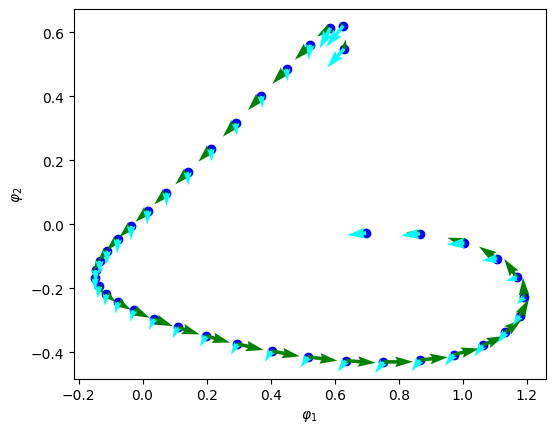

In [120]:
control_points = jax.random.normal(jax.random.PRNGKey(2), (10, 9))
curve = partial(BezierCurve(
    num_bends=control_points.shape[0]), cp=control_points)
d_bezier = partial(BezierCurve(
    num_bends=control_points.shape[0]).derivative_bezier, cp=control_points)
t_test = jnp.linspace(0., 1., 40)

t_cut, ortho_at_tcut = init_curve_frame(d_bezier)
space = generate_ortho_parallel_transport(
    t_test, d_bezier, t_cut, ortho_at_tcut)
curve_points = curve(t_test)

print(curve_points.shape, space.shape)
plt.scatter(curve_points[:, 0], curve_points[:, 1], c='b')
# plt.scatter(*control_points.T, c='r')
# plt.quiver(curve_points[:, 0], curve_points[:, 1], bezier_dirs[:, 0], bezier_dirs[:, 1])
plt.quiver(curve_points[:, 0], curve_points[:, 1],
           space[:, 0, 0], space[:, 0, 1], color='g', scale=10.)
plt.quiver(curve_points[:, 0], curve_points[:, 1],
           space[:, 1, 0], space[:, 1, 1], color='cyan', scale=10.)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$\varphi_1$')
plt.ylabel(r'$\varphi_2$')

In [140]:
# check if all vectors are orthogonal
corr = jnp.matmul(space, space.transpose(0, 2, 1))
corr = corr - jnp.eye(space.shape[-1])
print(f"Largest off diagonal: \n{jnp.max(jnp.abs(corr))} (expected to be zero)")

Largest off diagonal: 
3.5762786865234375e-07 (expected to be zero)
